In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import resample
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from econml.dr import DRLearner
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the CSV
df = pd.read_csv("Walmart_customer_purchases.csv")

In [4]:
# Show basic shape
print("Shape of dataset:", df.shape)

# View the first 5 rows
df.head()

Shape of dataset: (50000, 12)


,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,Electronics,Smartphone,2024-08-30,253.26,Cash on Delivery,No,1,Yes
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,Clothing,T-Shirt,2024-12-21,73.19,Debit Card,Yes,1,No
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,Beauty,Perfume,2024-12-26,125.62,Credit Card,Yes,1,No
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,Electronics,Smartwatch,2024-11-04,450.32,Credit Card,No,2,Yes
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,Electronics,Smartphone,2024-10-07,369.28,Credit Card,Yes,2,Yes


## Exploratory Data Analysis

#### Column Name & Data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer_ID       50000 non-null  object 
 1   Age               50000 non-null  int64  
 2   Gender            50000 non-null  object 
 3   City              50000 non-null  object 
 4   Category          50000 non-null  object 
 5   Product_Name      50000 non-null  object 
 6   Purchase_Date     50000 non-null  object 
 7   Purchase_Amount   50000 non-null  float64
 8   Payment_Method    50000 non-null  object 
 9   Discount_Applied  50000 non-null  object 
 10  Rating            50000 non-null  int64  
 11  Repeat_Customer   50000 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 4.6+ MB


- All columns have 50,000 non null values, meaning there are no missing values in the dataset.
- Most columns are categorical, while Age, Rating and Purchase_Amount are numerical.

#### Missing values

In [6]:
print(df.isnull().sum())

Customer_ID         0
Age                 0
Gender              0
City                0
Category            0
Product_Name        0
Purchase_Date       0
Purchase_Amount     0
Payment_Method      0
Discount_Applied    0
Rating              0
Repeat_Customer     0
dtype: int64


#### Unique Values

In [7]:
(df['Category'].value_counts()*100)/df.shape[0]

Category
Electronics    25.284
Home           24.984
Beauty         24.894
Clothing       24.838
Name: count, dtype: float64

In [8]:
df['City'].value_counts()

City
New Michael       44
North Michael     42
Lake Michael      41
East Michael      36
Port Michael      34
                  ..
New Cesar          1
West Larrystad     1
Mcleanton          1
West Lorishire     1
Shermantown        1
Name: count, Length: 25096, dtype: int64

In [9]:
(df['Repeat_Customer'].value_counts() * 100) / df.shape[0]

Repeat_Customer
Yes    50.488
No     49.512
Name: count, dtype: float64

Roughly half of the customers are repeat buyers, indicating a balanced mix of loyal and new customers in the dataset. This balance is useful for segmentation and analyzing customer retention behavior

In [10]:
(df['Discount_Applied'].value_counts() * 100) / df.shape[0]

Discount_Applied
No     50.036
Yes    49.964
Name: count, dtype: float64

Nearly 50-50 distribution. This implies the dataset is well suited for evaluating the impact of discounts since there is no strong imbalance between discounted and non-discounted transactions.

#### Duplicates

In [11]:
df.duplicated().sum()

np.int64(0)

## Visualization

#### To identify which cities bring in more customers

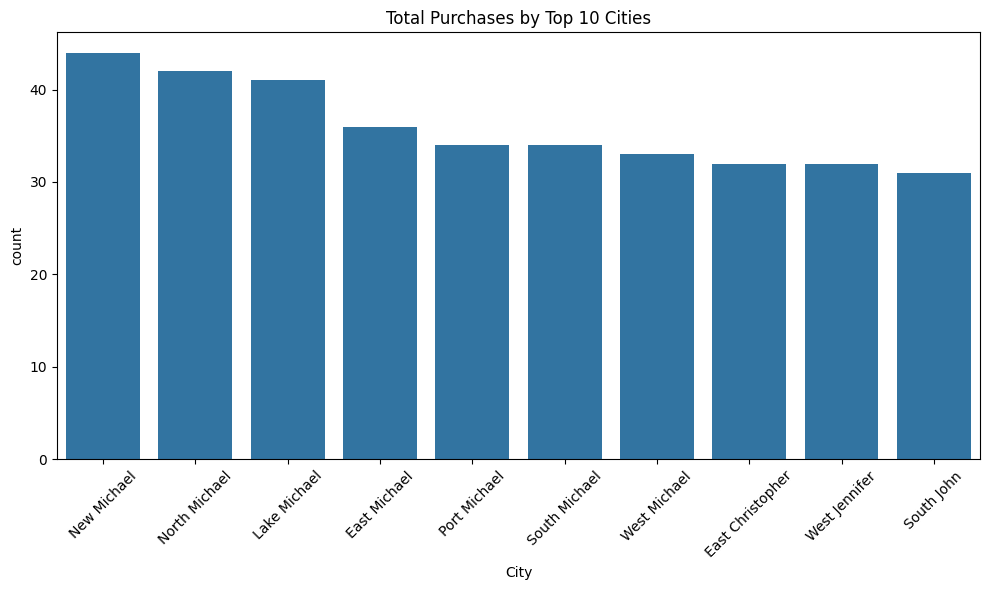

In [12]:
# Top 10 cities
top_cities = df['City'].value_counts().head(10).index

# Filter dataset
top_df = df[df['City'].isin(top_cities)]

plt.figure(figsize=(10,6))
sns.countplot(data=top_df, x='City', order=top_cities)
plt.title("Total Purchases by Top 10 Cities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The chart shows that purchases are relatively well distributed across the top 10 cities, with New Michael leading slightly.

#### Understand demographic targeting for pricing and segmentation.

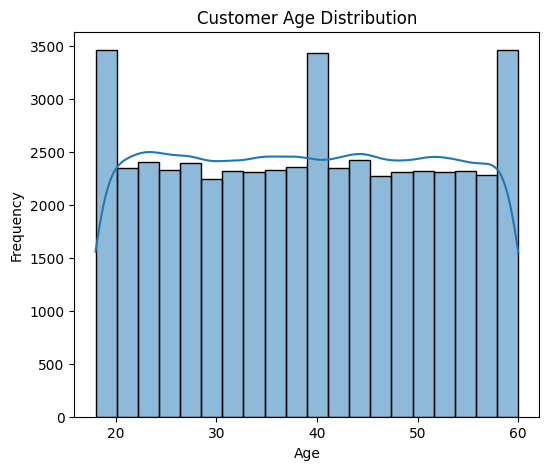

In [13]:
plt.figure(figsize=(6,5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

The plot shows a uniform age distribution between 18 and 60 with slight peaks at the lower (18–20) and upper (59–60) boundaries.

#### Identify best-selling categories for focused markdown planning.

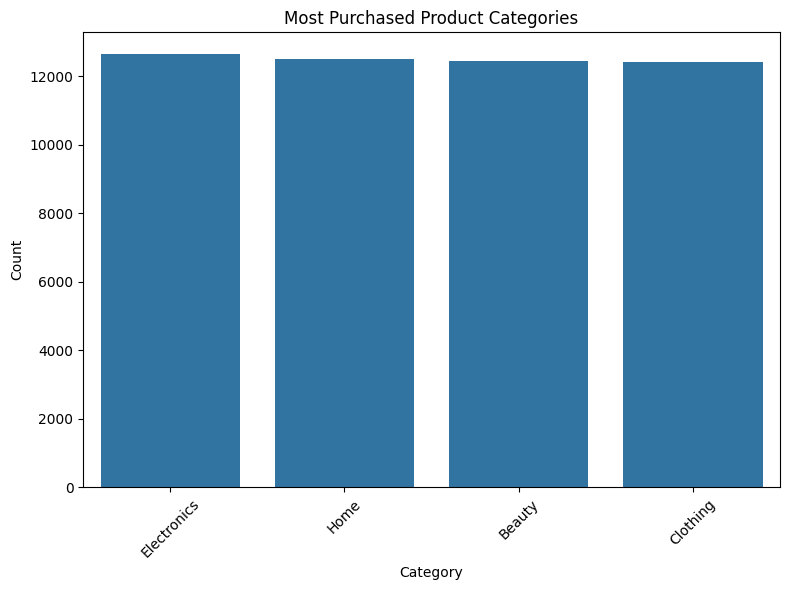

In [14]:
category_avg = df['Category'].value_counts().reset_index()
category_avg.columns = ['Category', 'Count']

plt.figure(figsize=(8,6))
sns.barplot(data=category_avg, x='Category', y='Count')
plt.title("Most Purchased Product Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot shows that purchases are evenly distributed across the top four product categories Electronics, Home, Beauty and Clothing with only minor variation in count, indicating balanced customer interest across diverse retail segments.

#### Spatial and temporal trend for pricing elasticity evaluation.

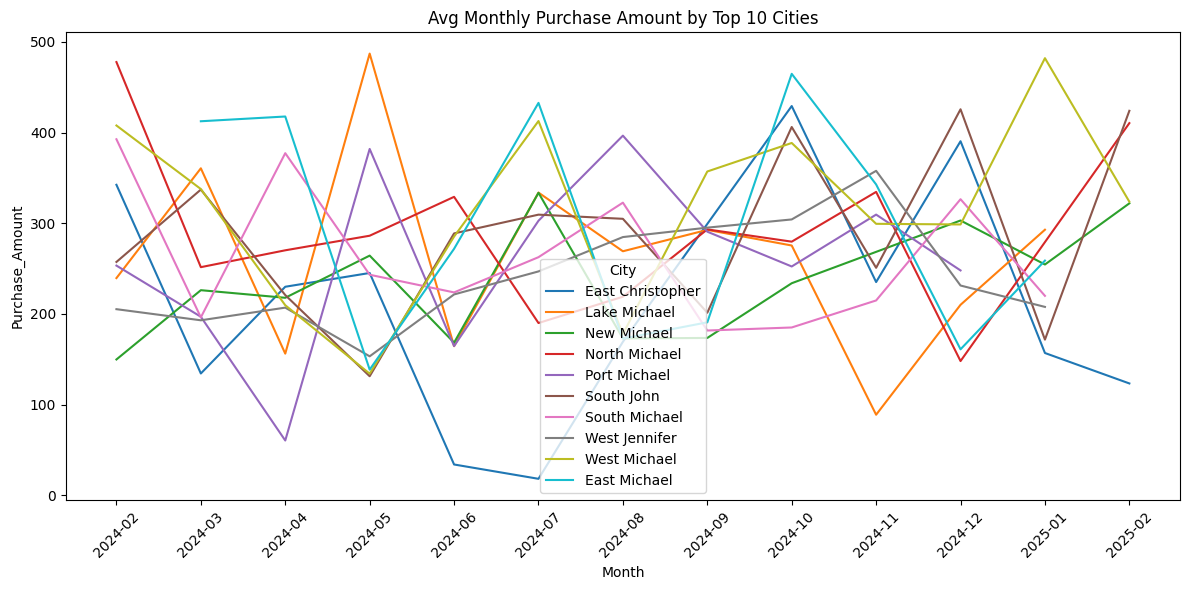

In [15]:
top_df['Purchase_Date'] = pd.to_datetime(top_df['Purchase_Date'])
top_df['Month'] = top_df['Purchase_Date'].dt.to_period('M').astype(str)

monthly_city = top_df.groupby(['Month', 'City'])['Purchase_Amount'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_city, x='Month', y='Purchase_Amount', hue='City')
plt.title("Avg Monthly Purchase Amount by Top 10 Cities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The line plot shows that average monthly purchase amounts vary significantly across the top 10 cities, with no consistent leader, indicating volatile spending patterns and differing customer behaviors over time in each location.

#### Detect seasonality or promotional effects by product line.

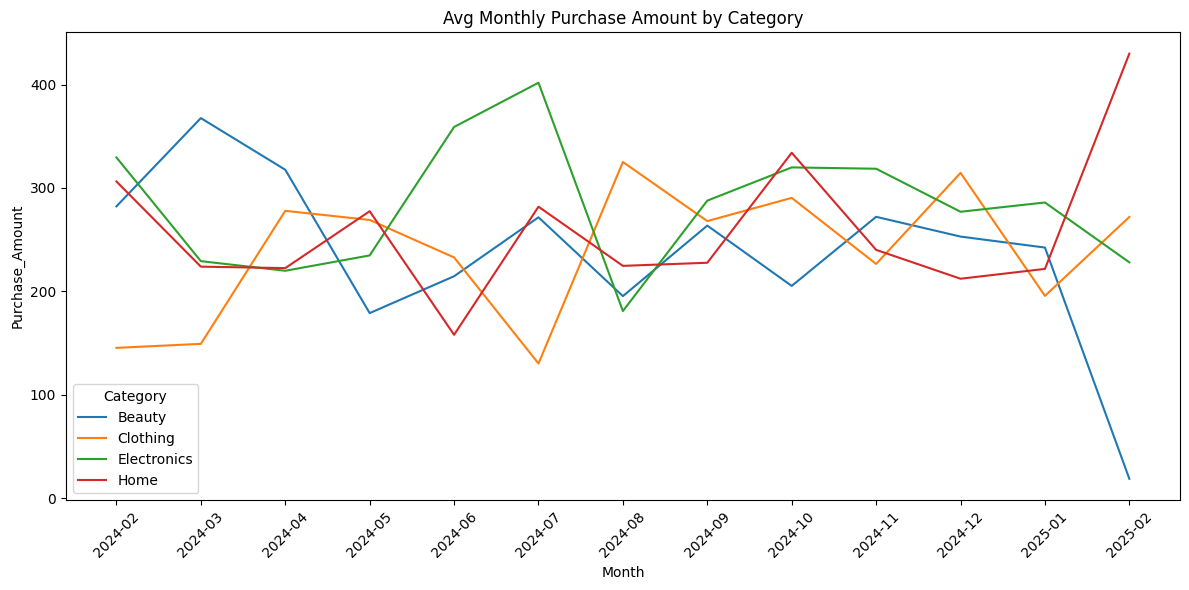

In [16]:
monthly_category = top_df.groupby(['Month', 'Category'])['Purchase_Amount'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_category, x='Month', y='Purchase_Amount', hue='Category')
plt.title("Avg Monthly Purchase Amount by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The line plot shows that average monthly purchase amounts vary notably across product categories, with Electronics and Home showing stronger and more volatile spending patterns over time, while Beauty exhibits a noticeable drop in early 2025, indicating shifting customer preferences.

#### Segment-wise effect of discounting

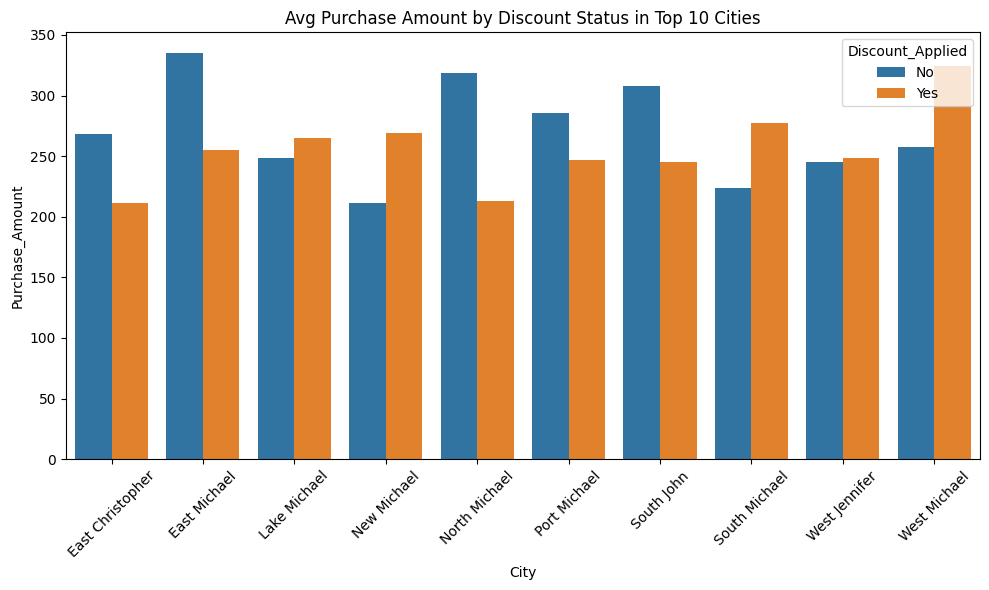

In [19]:
discount_impact = top_df.groupby(['City', 'Discount_Applied'])['Purchase_Amount'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=discount_impact, x='City', y='Purchase_Amount', hue='Discount_Applied')
plt.title("Avg Purchase Amount by Discount Status in Top 10 Cities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot compares the average purchase amount across the top 10 cities based on whether a discount was applied. It shows that in some cities (e.g. West Michael, South Michael), purchases with discounts are higher, indicating positive responsiveness to discounts, while in others (e.g. East Michael, North Michael), non-discounted purchases yield higher amounts, suggesting lower discount sensitivity.

#### which cities have loyal customers

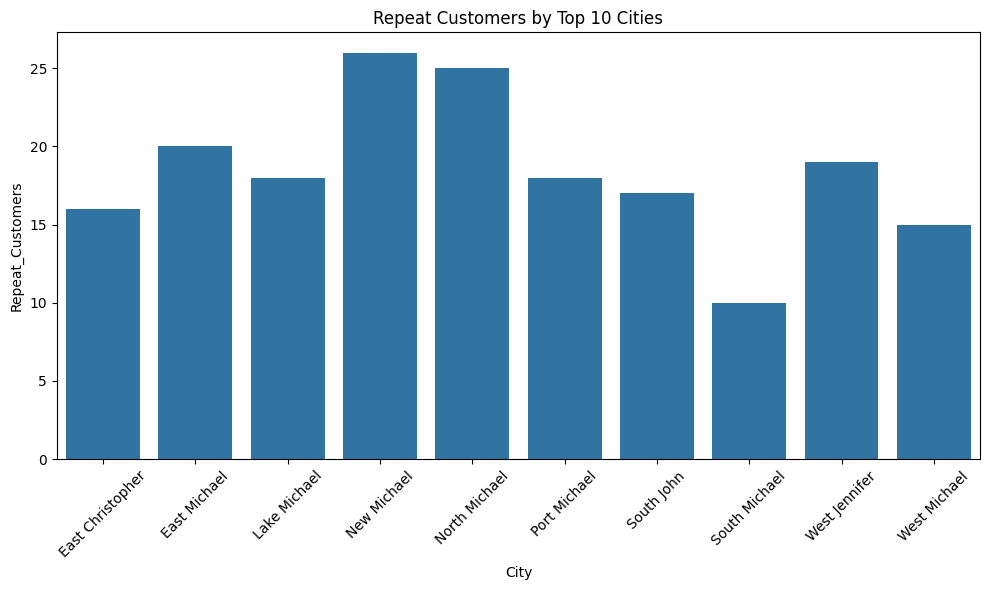

In [20]:
repeat_customers = top_df[top_df['Repeat_Customer'].str.lower() == 'yes']
repeat_counts = repeat_customers.groupby('City')['Customer_ID'].nunique().reset_index()
repeat_counts.columns = ['City', 'Repeat_Customers']

plt.figure(figsize=(10,6))
sns.barplot(data=repeat_counts, x='City', y='Repeat_Customers')
plt.title("Repeat Customers by Top 10 Cities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar chart shows the distribution of repeat customers across the top 10 cities. It indicates that New Michael and North Michael have the highest number of repeat customers, suggesting stronger customer retention in those regions. In contrast South Michael has the lowest number of repeat customers, which may point to weaker loyalty or less effective engagement strategies in that city.

#### Compare spend of repeat vs new customers

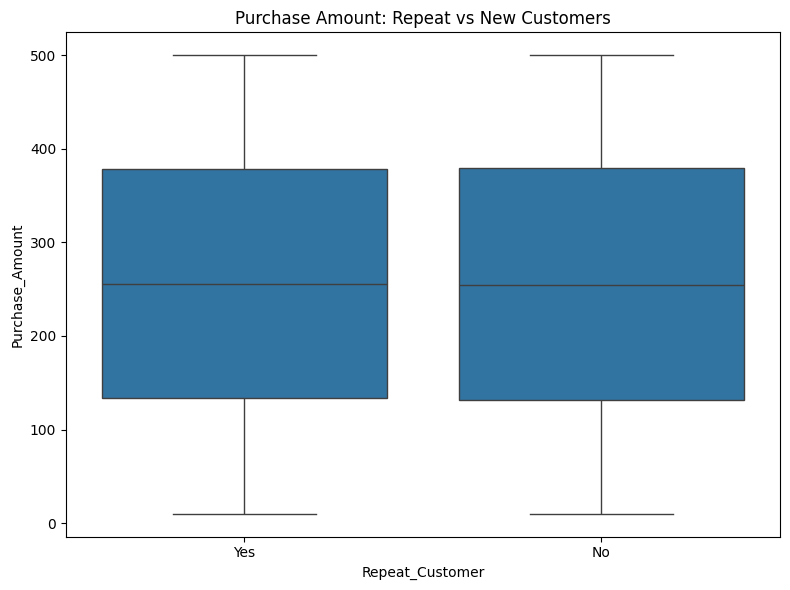

In [21]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Repeat_Customer', y='Purchase_Amount')
plt.title("Purchase Amount: Repeat vs New Customers")
plt.tight_layout()
plt.show()

## Hypothesis Testing

Hypothesis Testing: Do Discounts Increase Purchase Amount?
1. Business Question

Do customers who receive a discount tend to spend more than those who don’t?

2. Statistical Framing
Variable	Purchase_Amount
Group A	Discount = "Yes"
Group B	Discount = "No"
Test	Independent Samples T-test (or Mann-Whitney U if not normal)
Goal    Compare the means of two groups

3. Assumptions
- Data is independent.
- Normality of Purchase_Amount was checked using Shapiro-Wilk or visualize.
- If not normal then non-parametric test like Mann–Whitney U was used.

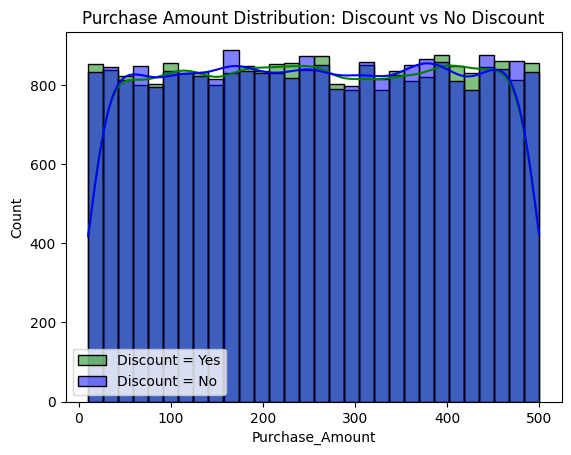

Shapiro p-value for Discount=Yes: 0.0000
Shapiro p-value for Discount=No: 0.0000

Mann-Whitney U: p = 0.9435


In [22]:
# Load data
df = pd.read_csv('Walmart_customer_purchases.csv')

# Clean Discount column
df['Discount_Applied'] = df['Discount_Applied'].str.strip().str.lower()

# Split into two groups
group_yes = df[df['Discount_Applied'] == 'yes']['Purchase_Amount']
group_no = df[df['Discount_Applied'] == 'no']['Purchase_Amount']

# Visualize distribution
sns.histplot(group_yes, kde=True, color='green', label='Discount = Yes')
sns.histplot(group_no, kde=True, color='blue', label='Discount = No')
plt.legend()
plt.title("Purchase Amount Distribution: Discount vs No Discount")
plt.show()

# Check normality
stat_yes, p_yes = shapiro(group_yes.sample(500, random_state=1))  
stat_no, p_no = shapiro(group_no.sample(500, random_state=1))

print(f"Shapiro p-value for Discount=Yes: {p_yes:.4f}")
print(f"Shapiro p-value for Discount=No: {p_no:.4f}")

# If both p > 0.05, assume t-test
if p_yes > 0.05 and p_no > 0.05:
    stat, p_value = ttest_ind(group_yes, group_no, equal_var=False)
    print(f"\nT-test: p = {p_value:.4f}")
else:
    stat, p_value = mannwhitneyu(group_yes, group_no, alternative='two-sided')
    print(f"\nMann-Whitney U: p = {p_value:.4f}")

p-value > 0.05 → No significant difference in purchase amount between customers with and without discounts.
So, discounts did not statistically increase purchase amounts.

## RFM Analysis

In [23]:
# Convert purchase date
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])

# Reference date = max date + 1
ref_date = df['Purchase_Date'].max() + pd.Timedelta(days=1)

# RFM aggregation
rfm = df.groupby('Customer_ID').agg({
    'Purchase_Date': lambda x: (ref_date - x.max()).days,
    'Customer_ID': 'count',
    'Purchase_Amount': 'sum'
}).rename(columns={
    'Purchase_Date': 'Recency',
    'Customer_ID': 'Frequency',
    'Purchase_Amount': 'Monetary'
})

rfm.reset_index(inplace=True)

In [24]:
rfm

,Customer_ID,Recency,Frequency,Monetary
0,000181a8-a961-4865-922f-ec14ac3a6290,270,1,94.03
1,00028cdf-0ea6-493f-9f96-df6d50cfa975,64,1,87.38
2,0003f5b9-0a75-4108-94e2-e960aa99d2a3,350,1,394.37
3,0008375d-c94d-45aa-9ce4-f2e21777cbd5,343,1,233.91
4,0008c27f-5b3e-452e-8fb3-dd1744592d14,219,1,194.11
...,...,...,...,...
49995,fff78fae-7d8c-4af7-a513-b6780cf22547,309,1,331.99
49996,fff7d7da-086a-4cc3-8fae-ac09a75df702,59,1,115.00
49997,fff905ba-e803-4150-998c-e6ac02f8c097,298,1,487.54
49998,fffb54c4-28d4-4da8-adaa-d8d0c3f626b4,263,1,187.18


This table shows a preview of the RFM dataset (Recency, Frequency, Monetary) used for customer segmentation. Each row represents a unique Customer_ID with:

**Recency:** Days since their last purchase.
<br>**Frequency:** All values are 1, indicating that each customer made only one purchase.
<br>**Monetary:** The total purchase amount by that customer.

This confirms that the dataset is prepared for RFM analysis, though the uniform frequency (1 for all) justifies the decision to omit it from segmentation and focus instead on Recency and Monetary.

#### Feature Scaling

Since Recency, Frequency, Monetary have very different scales, we must normalize before clustering.

In [25]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

#### Elbow Method

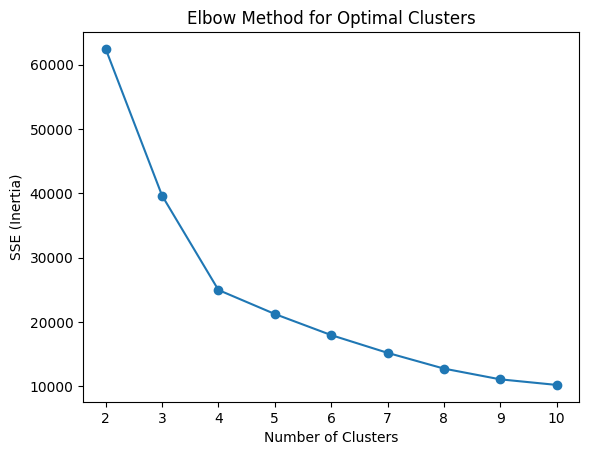

In [26]:
sse = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)

plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

In [28]:
# Segment profile
cluster_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer_ID': 'count'
}).rename(columns={'Customer_ID': 'Count'})

print(cluster_summary)

            Recency  Frequency    Monetary  Count
Segment                                          
0        275.928688        1.0  380.529062  12298
1         90.342996        1.0  132.794667  12522
2        274.743838        1.0  134.105562  12578
3         93.820743        1.0  376.704530  12602


## Clustering with new groups

In [2]:
# Convert Purchase_Date to datetime and calculate Recency
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])
latest_date = df['Purchase_Date'].max()
rf = df.groupby('Customer_ID').agg({
    'Purchase_Date': lambda x: (latest_date - x.max()).days,
    'Purchase_Amount': 'sum',
    'Discount_Applied': 'last',
    'Payment_Method': 'last',
    'Category': 'last',
    'Repeat_Customer': 'last'
}).reset_index().rename(columns={
    'Purchase_Date': 'Recency',
    'Purchase_Amount': 'Monetary'
})

# Clean text fields
rf['Discount_Applied'] = rf['Discount_Applied'].str.strip().str.lower()
rf['Repeat_Customer'] = rf['Repeat_Customer'].str.strip().str.lower()

# Convert 'yes'/'no' to 1/0
rf['Discount_Applied'] = rf['Discount_Applied'].map({'yes': 1, 'no': 0})
rf['Repeat_Customer'] = rf['Repeat_Customer'].map({'yes': 1, 'no': 0})

# One-hot encode categorical features
categorical_features = ['Payment_Method', 'Category']
numeric_features = ['Recency', 'Monetary']
binary_features = ['Discount_Applied', 'Repeat_Customer']


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough') 

X_prepared = preprocessor.fit_transform(rf.drop(columns=['Customer_ID']))
# # Drop non-numeric identifier
# X_prepared = rf.drop(columns=['Customer_ID'])

# View shape before clustering
print("Prepared data shape:", X_prepared.shape)

NameError: name 'pd' is not defined

In [30]:
# Get one-hot column names
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine all column names
final_cols = list(numeric_features) + list(encoded_cols) + list(binary_features)

print(final_cols)


['Recency', 'Monetary', 'Payment_Method_Credit Card', 'Payment_Method_Debit Card', 'Payment_Method_UPI', 'Category_Clothing', 'Category_Electronics', 'Category_Home', 'Discount_Applied', 'Repeat_Customer']


In [31]:
X_prepared[0]

array([ 0.82033693, -1.14076999,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  1.        ])

#### Optimal Cluster Count (Elbow & Silhouette)

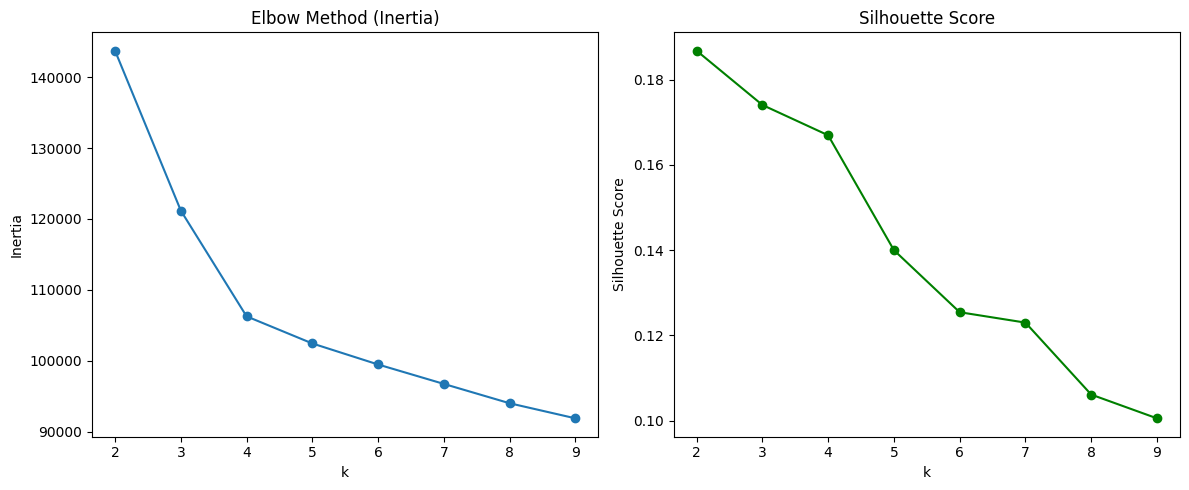

In [32]:
# Elbow method
inertia = []
silhouette = []
K_range = range(2, 10)

# Sample for silhouette only
sampled_data = resample(X_prepared, n_samples=5000, random_state=42)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_prepared)
    inertia.append(kmeans.inertia_)
    # silhouette.append(silhouette_score(X_prepared, kmeans.labels_))

    labels = kmeans.predict(sampled_data)  # use the sampled data for silhouette
    silhouette.append(silhouette_score(sampled_data, labels))

# Plotting
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

This figure shows the cluster validation results using two key methods:
<br>**Elbow Method:**
As the number of clusters (k) increases, inertia (within cluster sum of squares) decreases. The elbow appears around k = 4, where the rate of decrease sharply flattens, suggesting 4 is an optimal number of clusters.

**Silhouette Score:**
The silhouette score, which measures how well separated the clusters are, is highest at k = 2 but it drops significantly after k = 4. This supports choosing k = 4 as a balance between cluster cohesion and separation.

In [33]:
# From the plot k=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rf['Segment'] = kmeans.fit_predict(X_prepared)

#### Visualizing clusters (Using PCA)

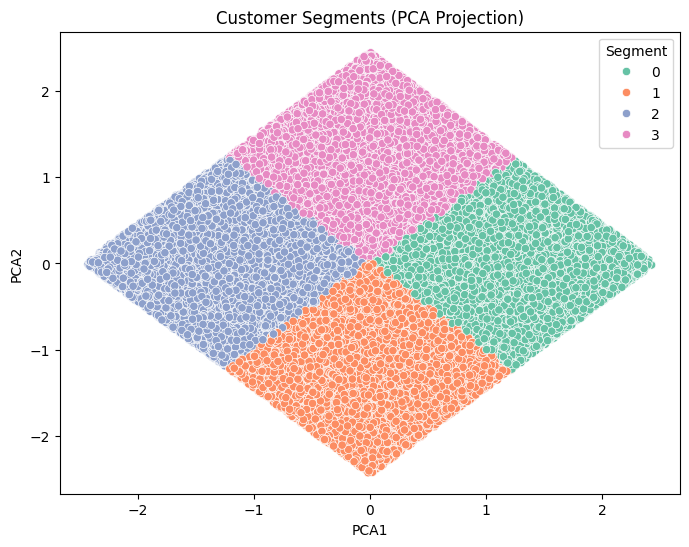

In [34]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prepared)
rf['PCA1'] = X_pca[:, 0]
rf['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rf, x='PCA1', y='PCA2', hue='Segment', palette='Set2')
plt.title('Customer Segments (PCA Projection)')
plt.show()

Customer segments are well separated and balanced in the PCA space, indicating effective clustering and strong potential for segment specific marketing strategies.
<br>- **Segment 0 – Loyal High Spenders:** Customers who purchase frequently without relying on discounts and contribute high revenue ideal for loyalty and premium targeting.
<br>- **Segment 1 – Price-Sensitive Repeat Buyers:** Repeat customers who respond well to discounts and offers suitable for targeted promotions and bundling strategies.
<br>- **Segment 2 – Infrequent Bargain Seekers:** Low spending, irregular buyers driven mostly by discounts best reached through reactivation campaigns.
<br>- **Segment 3 – New or Occasional Customers:** New or one time buyers with moderate spending; can be nurtured into loyal customers with onboarding offers and personalized messaging.

In [35]:
cluster_profile = rf.groupby('Segment').agg({
    'Recency': 'mean',
    'Monetary': 'mean',
    'Discount_Applied': 'mean',
    'Repeat_Customer': 'mean'
}).round(2)

print(cluster_profile)


         Recency  Monetary  Discount_Applied  Repeat_Customer
Segment                                                      
0         274.32    380.68               0.5             0.51
1          92.23    376.43               0.5             0.51
2          89.85    132.43               0.5             0.51
3         274.26    134.37               0.5             0.50


#### Temporal trends per Segment

We'll generate monthly trends based on:

- Segment counts

- Avg purchase amount per segment

- Discount usage per segment

In [36]:
# Merge cluster labels with original dataframe
rf['Segment'] = kmeans.labels_
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])

# Merge original df with cluster assignments
df = df.merge(rf[['Customer_ID', 'Segment']], on='Customer_ID', how='left')

# Extract month
df['Month'] = df['Purchase_Date'].dt.to_period('M').astype(str)

# Group and analyze
monthly_summary = df.groupby(['Month', 'Segment']).agg({
    'Customer_ID': 'nunique',  # Customer count
    'Purchase_Amount': 'mean',
    'Discount_Applied': lambda x: (x.str.lower() == 'yes').mean()
}).reset_index().rename(columns={
    'Customer_ID': 'Customer_Count',
    'Purchase_Amount': 'Avg_Purchase_Amount',
    'Discount_Applied': 'Discount_Rate'
})


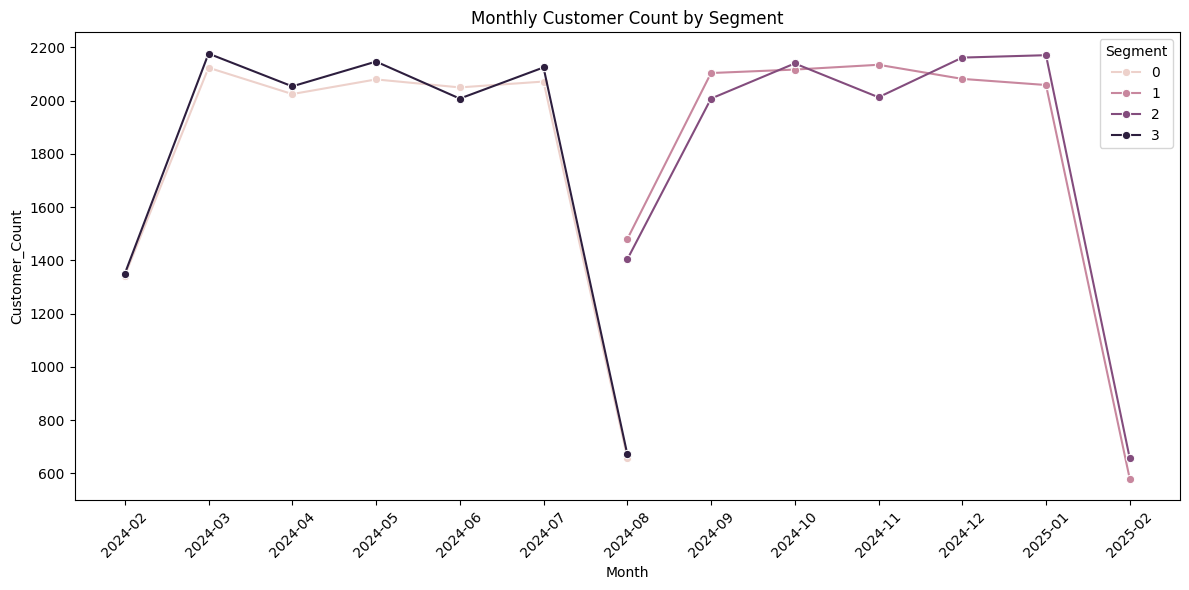

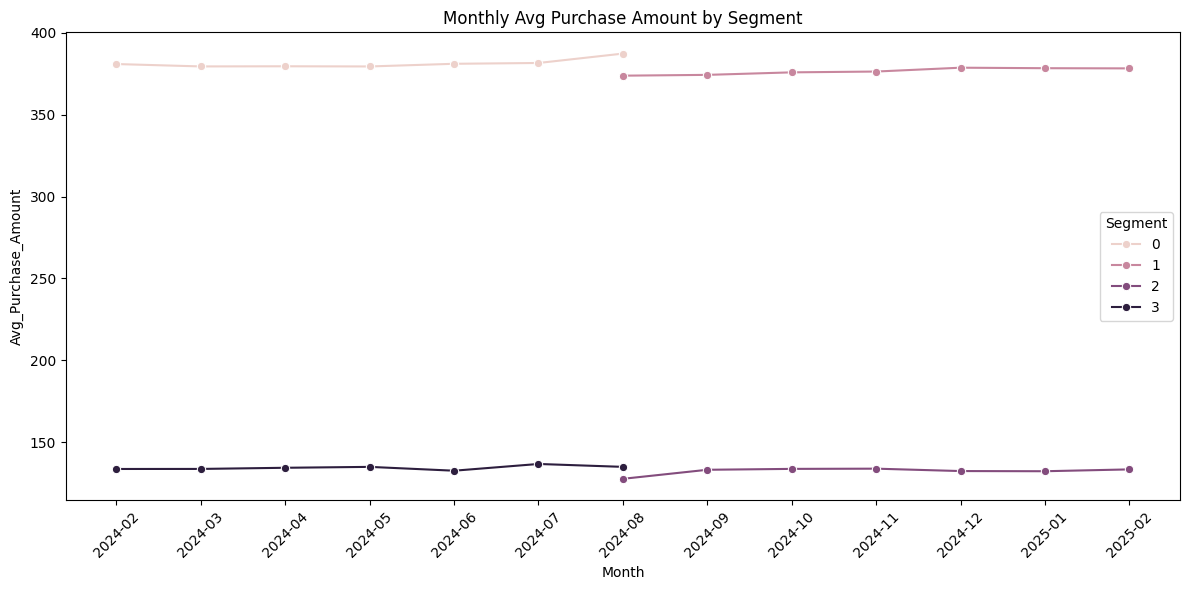

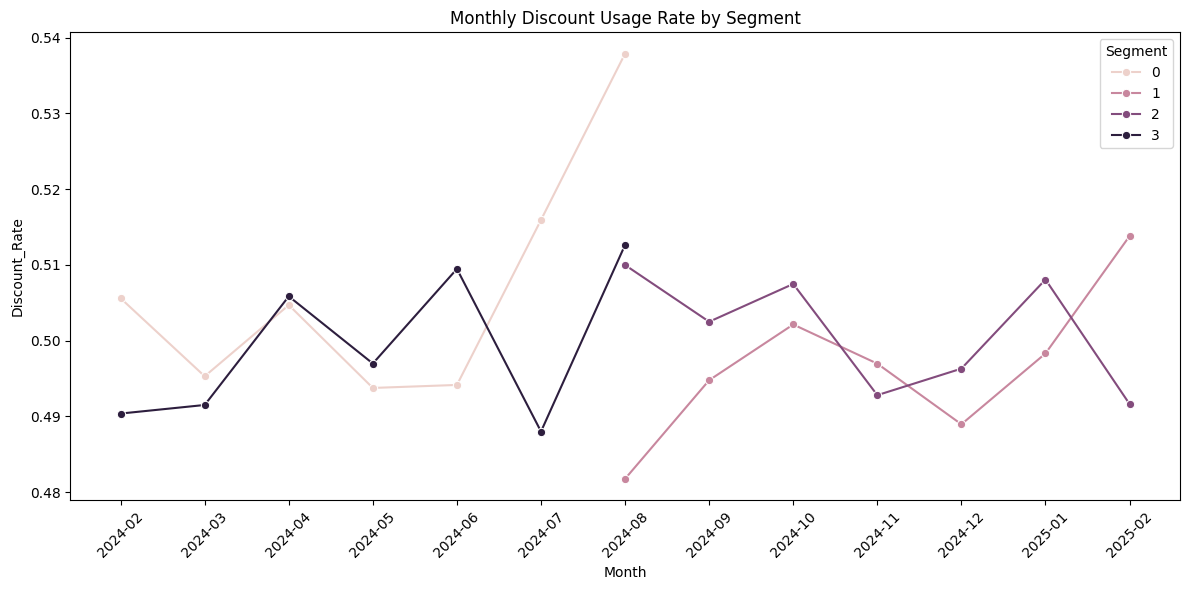

In [37]:
# Trend 1: Customer count per segment over time
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_summary, x='Month', y='Customer_Count', hue='Segment', marker='o')
plt.title('Monthly Customer Count by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Trend 2: Avg Purchase per segment
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_summary, x='Month', y='Avg_Purchase_Amount', hue='Segment', marker='o')
plt.title('Monthly Avg Purchase Amount by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Trend 3: Discount rate per segment
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_summary, x='Month', y='Discount_Rate', hue='Segment', marker='o')
plt.title('Monthly Discount Usage Rate by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Discount uplift per Segment

In [38]:
# Clean up Yes/No values (only if not yet converted)
df['Discount_Applied'] = df['Discount_Applied'].str.lower().map({'yes': 1, 'no': 0})

# Group by Segment & Discount_Applied
uplift = df.groupby(['Segment', 'Discount_Applied'])['Purchase_Amount'].mean().unstack()

# Calculate uplift
uplift['Uplift (%)'] = ((uplift[1] - uplift[0]) / uplift[0]) * 100
uplift = uplift.rename(columns={0: 'No Discount', 1: 'With Discount'})

print(uplift.round(2))


Discount_Applied  No Discount  With Discount  Uplift (%)
Segment                                                 
0                      380.46         380.89        0.11
1                      376.44         376.43       -0.00
2                      131.86         132.99        0.86
3                      134.63         134.11       -0.38


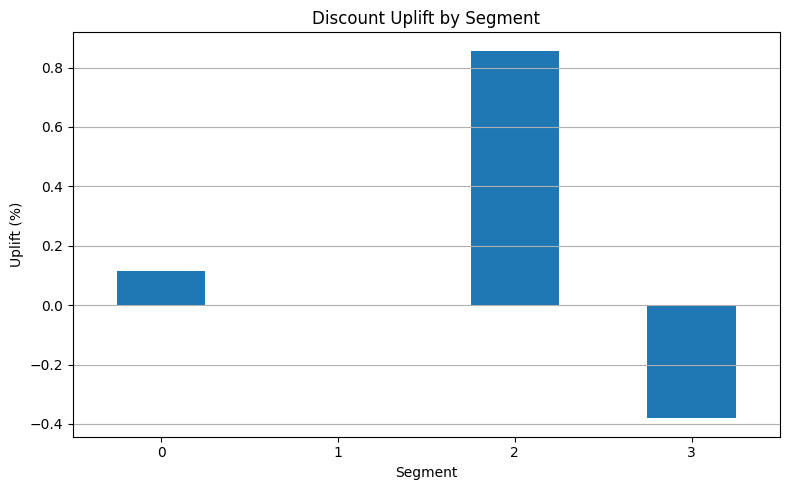

In [39]:
uplift['Uplift (%)'].plot(kind='bar', figsize=(8,5), title='Discount Uplift by Segment', ylabel='Uplift (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- **Segment 0:**
Shows a small positive uplift (~0.1%) indicating a modest benefit from offering discounts. These customers respond slightly better with discounts but not significantly.<br>

- **Segment 1:**
Has no uplift recorded (0%) implying that discounts had no measurable impact on their purchasing behavior.<br>

- **Segment 2:**
Displays a strong positive uplift (~0.85%) meaning discounts significantly increased purchases for this group they are the most discount-responsive segment.<br>

- **Segment 3:**
Exhibits a negative uplift (~-0.38%) suggesting that discounts had an adverse or no economic impact these customers may have purchased anyway or reacted less positively.

Only Segment 2 should be prioritized for discount based campaigns as they show the highest return on investment. Segment 3 may not be ideal for discount targeting due to diminishing returns.

## Price Elasticity

#### Monthly average price per Segment

In [40]:
monthly_avg_price = df.groupby(['Month', 'Segment'])['Purchase_Amount'].mean().reset_index()
monthly_avg_price.rename(columns={'Purchase_Amount': 'Avg_Purchase_Amount'}, inplace=True)

In [41]:
monthly_avg_price

,Month,Segment,Avg_Purchase_Amount
0,2024-02,0,380.919025
1,2024-02,3,133.607511
2,2024-03,0,379.466610
3,2024-03,3,133.637221
4,2024-04,0,379.559136
5,2024-04,3,134.342950
6,2024-05,0,379.450135
7,2024-05,3,134.891337
8,2024-06,0,381.076268
9,2024-06,3,132.550508


#### Monthly customer count per Segment

In [42]:
monthly_customer_count = df.groupby(['Month', 'Segment'])['Customer_ID'].nunique().reset_index()
monthly_customer_count.rename(columns={'Customer_ID': 'Customer_Count'}, inplace=True)

In [43]:
monthly_customer_count

,Month,Segment,Customer_Count
0,2024-02,0,1343
1,2024-02,3,1350
2,2024-03,0,2124
3,2024-03,3,2177
4,2024-04,0,2025
5,2024-04,3,2054
6,2024-05,0,2080
7,2024-05,3,2147
8,2024-06,0,2050
9,2024-06,3,2008


In [44]:
df_merged = pd.merge(monthly_avg_price, monthly_customer_count, on=['Month', 'Segment'])
df_merged = df_merged.sort_values(by=['Segment', 'Month'])
df_merged

,Month,Segment,Avg_Purchase_Amount,Customer_Count
0,2024-02,0,380.919025,1343
2,2024-03,0,379.466610,2124
4,2024-04,0,379.559136,2025
6,2024-05,0,379.450135,2080
8,2024-06,0,381.076268,2050
10,2024-07,0,381.574295,2072
12,2024-08,0,387.305212,660
13,2024-08,1,373.820986,1480
16,2024-09,1,374.312937,2104
18,2024-10,1,375.844842,2117


#### Compute percentage change over Month

In [45]:
df_merged['Price_Change_%'] = df_merged.groupby('Segment')['Avg_Purchase_Amount'].pct_change()
df_merged['Customer_Change_%'] = df_merged.groupby('Segment')['Customer_Count'].pct_change()

#### Compute Psuedo Elasticity

In [46]:
df_merged['Pseudo_Elasticity'] = df_merged['Customer_Change_%'] / df_merged['Price_Change_%']

# Filter Extreme/Infinite Values
df_clean = df_merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['Pseudo_Elasticity'])

In [47]:
elasticity_summary = df_clean.groupby('Segment')['Pseudo_Elasticity'].mean().reset_index()
elasticity_summary

,Segment,Pseudo_Elasticity
0,0,-79.796461
1,1,457.656161
2,2,-21.409925
3,3,468.939439


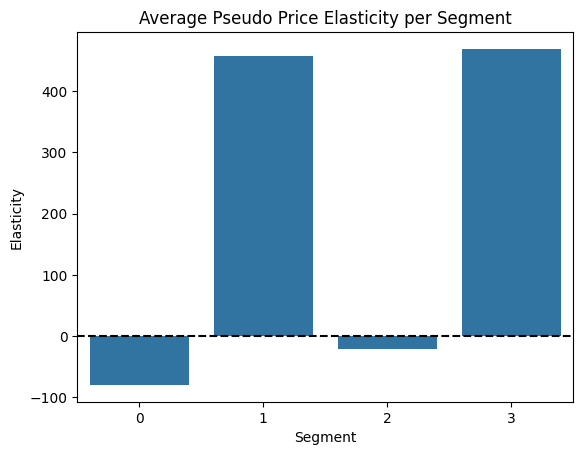

In [48]:
sns.barplot(x='Segment', y='Pseudo_Elasticity', data=elasticity_summary)
plt.axhline(0, color='black', linestyle='--')
plt.title('Average Pseudo Price Elasticity per Segment')
plt.ylabel('Elasticity')
plt.xlabel('Segment')
plt.show()

#### Cross-check Discount Usage in Segments 1 & 3

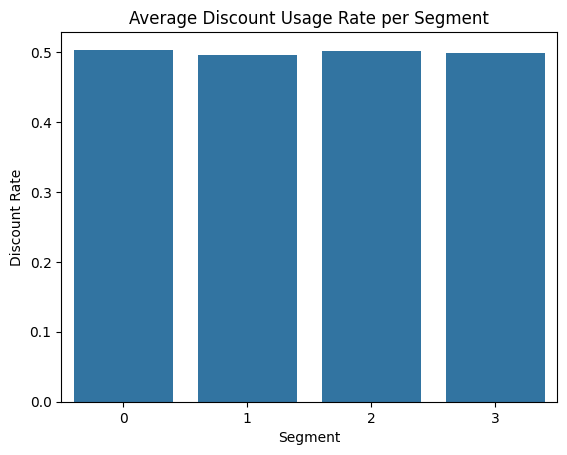

In [49]:
# Calculate discount rate per segment
discount_rate = df.groupby('Segment')['Discount_Applied'].mean().reset_index()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=discount_rate, x='Segment', y='Discount_Applied')
plt.title('Average Discount Usage Rate per Segment')
plt.ylabel('Discount Rate')
plt.show()


## Category-wise Purchase Patterns per Segment

In [50]:
df.columns

Index(['Customer_ID', 'Age', 'Gender', 'City', 'Category', 'Product_Name',
       'Purchase_Date', 'Purchase_Amount', 'Payment_Method',
       'Discount_Applied', 'Rating', 'Repeat_Customer', 'Segment', 'Month'],
      dtype='object')

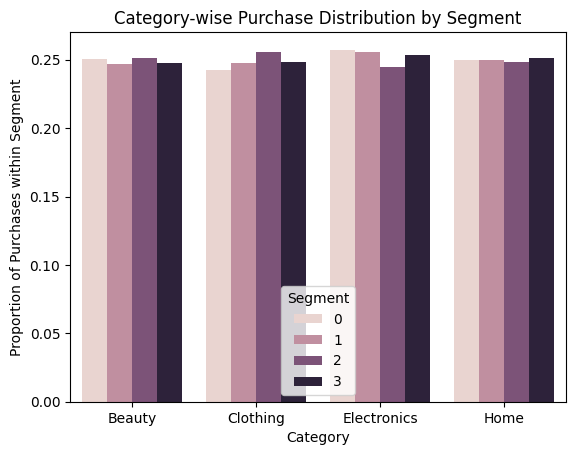

In [51]:
# Group by Segment and Category to count purchases
category_segment_counts = df.groupby(['Segment', 'Category']).size().reset_index(name='Purchase_Count')

# Normalize within each segment to show preference
category_segment_counts['Segment_Share'] = category_segment_counts['Purchase_Count'] / category_segment_counts.groupby('Segment')['Purchase_Count'].transform('sum')

# Plot: Category Preference per Segment
sns.barplot(data=category_segment_counts, x='Category', y='Segment_Share', hue='Segment')
plt.title("Category-wise Purchase Distribution by Segment")
plt.ylabel("Proportion of Purchases within Segment")
plt.show()


- Beauty: Segment 0 has the highest proportion, closely followed by other segments fairly uniform interest across all segments.<br>

- Clothing: Segment 2 prefers clothing more than others suggesting a fashion conscious segment.<br>

- Electronics: Segment 0 shows the strongest preference, possibly indicating a tech savvy group, while Segment 2 shows relatively less interest.<br>

- Home: All segments show very similar interest, with slightly higher preference from Segment 3.<br>

Each segment has a fairly balanced category distribution but Segment 2 leans more towards Clothing, Segment 0 prefers Electronics while Home products are consistently popular across all segments.

In [52]:
df

,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer,Segment,Month
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,Electronics,Smartphone,2024-08-30,253.26,Cash on Delivery,0,1,Yes,1,2024-08
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,Clothing,T-Shirt,2024-12-21,73.19,Debit Card,1,1,No,2,2024-12
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,Beauty,Perfume,2024-12-26,125.62,Credit Card,1,1,No,2,2024-12
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,Electronics,Smartwatch,2024-11-04,450.32,Credit Card,0,2,Yes,1,2024-11
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,Electronics,Smartphone,2024-10-07,369.28,Credit Card,1,2,Yes,1,2024-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,80853da9-ef96-4c83-9191-bc872c3968a9,48,Male,Barbaramouth,Electronics,Laptop,2024-11-18,391.48,Debit Card,0,5,No,1,2024-11
49996,97df1ed3-4041-474c-8ce8-958c816fc30a,51,Female,Troyshire,Beauty,Perfume,2024-11-19,272.09,Cash on Delivery,1,1,No,1,2024-11
49997,948efe87-82a3-4a38-9dd6-30d44ad6f879,51,Male,South Rachel,Home,Curtains,2024-02-11,280.81,Debit Card,1,2,No,0,2024-02
49998,9804d52f-35cd-4af3-a9e3-cbb8367396f0,33,Other,Courtneyville,Beauty,Shampoo,2024-08-31,140.74,Debit Card,0,2,No,2,2024-08


## AB TEST

In [55]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulate customer dataset
n_customers = 50000
segments = [0, 1, 2, 3]
data = {
    'Customer_ID': np.arange(n_customers),
    'Segment': np.random.choice(segments, size=n_customers),
    'Converted': np.random.binomial(1, 0.9, n_customers),  # 90% conversion baseline
    'Purchase_Amount': np.random.normal(225, 20, size=n_customers).clip(50, 500)
}
df = pd.DataFrame(data)

# A/B test parameters
discount_levels = [0.05, 0.10, 0.15]   # 5%, 10%, 15%
cost_percentages = [0.3, 0.4, 0.5]     # Cost as % of price

# Result container
results = []

# Run test per segment, discount level, and cost level
for segment in segments:
    df_segment = df[df['Segment'] == segment].copy()
    n_seg = len(df_segment)

    for discount in discount_levels:
        for cost_pct in cost_percentages:
            # Assign A/B groups
            df_segment['Group'] = np.random.choice(['A', 'B'], size=n_seg)

            # Apply discount to group B
            df_segment['Price'] = df_segment['Purchase_Amount']
            df_segment.loc[df_segment['Group'] == 'B', 'Price'] *= (1 - discount)

            # Compute metrics per group
            summary = df_segment.groupby('Group').agg({
                'Converted': 'mean',
                'Price': 'mean'
            }).rename(columns={'Converted': 'Conversion_Rate', 'Price': 'Avg_Purchase_Value'}).reset_index()

            # Calculate total margin
            df_segment['Revenue'] = df_segment['Converted'] * df_segment['Price']
            df_segment['Margin'] = df_segment['Revenue'] * (1 - cost_pct)
            margin_summary = df_segment.groupby('Group')['Margin'].sum().reset_index(name='Total_Margin')

            # Merge results
            merged = pd.merge(summary, margin_summary, on='Group')
            merged['Segment'] = segment
            merged['Discount'] = discount
            merged['Cost_Pct'] = cost_pct
            results.append(merged)

# Combine and view results
results_df = pd.concat(results, ignore_index=True)
results_df = results_df[['Segment', 'Discount', 'Cost_Pct', 'Group', 'Conversion_Rate', 'Avg_Purchase_Value', 'Total_Margin']]

# Save to CSV 
results_df.to_csv("segment_discount_abtest_results.csv", index=False)

# Show top 10 profitable settings
results_df.sort_values(by='Total_Margin', ascending=False).head(10)


,Segment,Discount,Cost_Pct,Group,Conversion_Rate,Avg_Purchase_Value,Total_Margin
54,3,0.05,0.3,A,0.903190,225.337786,906764.576026
66,3,0.15,0.3,A,0.904153,224.981280,902632.997241
12,0,0.15,0.3,A,0.899448,225.059919,897476.710797
6,0,0.10,0.3,A,0.900190,224.930162,895630.344985
0,0,0.05,0.3,A,0.899067,225.145915,895302.397995
24,1,0.10,0.3,A,0.907274,224.808675,893193.121700
36,2,0.05,0.3,A,0.902665,225.200133,891623.175430
60,3,0.10,0.3,A,0.898799,225.453459,886064.744627
18,1,0.05,0.3,A,0.904486,224.882134,885738.268900
48,2,0.15,0.3,A,0.901608,224.973914,883153.579776


## Uplift Modelling

#### Data Preparation

In [53]:
# Encode categorical vars
le = LabelEncoder()
df['Payment_Method'] = le.fit_transform(df['Payment_Method'])
df['Category'] = le.fit_transform(df['Category'])


In [54]:
df

,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer,Segment,Month
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,2,Smartphone,2024-08-30,253.26,0,0,1,Yes,1,2024-08
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,1,T-Shirt,2024-12-21,73.19,2,1,1,No,2,2024-12
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,0,Perfume,2024-12-26,125.62,1,1,1,No,2,2024-12
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,2,Smartwatch,2024-11-04,450.32,1,0,2,Yes,1,2024-11
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,2,Smartphone,2024-10-07,369.28,1,1,2,Yes,1,2024-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,80853da9-ef96-4c83-9191-bc872c3968a9,48,Male,Barbaramouth,2,Laptop,2024-11-18,391.48,2,0,5,No,1,2024-11
49996,97df1ed3-4041-474c-8ce8-958c816fc30a,51,Female,Troyshire,0,Perfume,2024-11-19,272.09,0,1,1,No,1,2024-11
49997,948efe87-82a3-4a38-9dd6-30d44ad6f879,51,Male,South Rachel,3,Curtains,2024-02-11,280.81,2,1,2,No,0,2024-02
49998,9804d52f-35cd-4af3-a9e3-cbb8367396f0,33,Other,Courtneyville,0,Shampoo,2024-08-31,140.74,2,0,2,No,2,2024-08


#### Label Engineering

In [70]:
df['Response'] = (df['Purchase_Amount'] >= 100).astype(int) 
features = ['Age', 'Gender', 'Category', 'Payment_Method', 'Repeat_Customer', 'Segment']
data = df.dropna(subset=features + ['Response', 'Discount_Applied'])

X = pd.get_dummies(data[features], drop_first=True)
T = data['Discount_Applied']  # Treatment: Discount given
Y = data['Response']          # Outcome: High purchase

In [71]:
# Split data
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

# Model for outcome and treatment
model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = LogisticRegression()

# EconML Estimator
est = LinearDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    random_state=42
)

# Fit the estimator
est.fit(Y_train, T_train, X=X_train)

results = []

# 1. EconML DR Learner 
dr = DRLearner(model_regression=RandomForestRegressor(),
               model_propensity=LogisticRegression())
dr.fit(Y=Y_train, T=T_train, X=X_train)
cate_dr = dr.effect(X_test)

results.append({
    'Model': 'EconML_DR',
    'Avg_Uplift': np.mean(cate_dr),
    'Uplift_Var': np.var(cate_dr),
    'CrossVal_R2_Y': np.mean(cross_val_score(RandomForestRegressor(), X, Y, cv=3, scoring='r2')),
    'Stability_StdDev': np.std(cate_dr),
    'Interpretability': 'Moderate',
    'Model_Type': 'Two-Model, Causal'
})


# 2. XGBoost Uplift 
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(np.column_stack((X_train, T_train)), Y_train)

y_pred_treat = xgb.predict_proba(np.column_stack((X_test, np.ones_like(T_test))))[:, 1]
y_pred_control = xgb.predict_proba(np.column_stack((X_test, np.zeros_like(T_test))))[:, 1]
cate_xgb = y_pred_treat - y_pred_control

results.append({
    'Model': 'XGBoost_Uplift',
    'Avg_Uplift': np.mean(cate_xgb),
    'Uplift_Var': np.var(cate_xgb),
    'CrossVal_Accuracy': np.mean(cross_val_score(XGBClassifier(eval_metric='logloss'), np.column_stack((X, T)), Y, cv=3)),
    'Stability_StdDev': np.std(cate_xgb),
    'Interpretability': 'Low',
    'Model_Type': 'T-Learner'
})


# 3. RandomForest Uplift 
rf = RandomForestClassifier()
rf.fit(np.column_stack((X_train, T_train)), Y_train)

y_pred_treat_rf = rf.predict_proba(np.column_stack((X_test, np.ones_like(T_test))))[:, 1]
y_pred_control_rf = rf.predict_proba(np.column_stack((X_test, np.zeros_like(T_test))))[:, 1]
cate_rf = y_pred_treat_rf - y_pred_control_rf

results.append({
    'Model': 'RandomForest_Uplift',
    'Avg_Uplift': np.mean(cate_rf),
    'Uplift_Var': np.var(cate_rf),
    'CrossVal_Accuracy': np.mean(cross_val_score(RandomForestClassifier(), np.column_stack((X, T)), Y, cv=3)),
    'Stability_StdDev': np.std(cate_rf),
    'Interpretability': 'Medium',
    'Model_Type': 'T-Learner'
})

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Avg_Uplift,Uplift_Var,CrossVal_R2_Y,Stability_StdDev,Interpretability,Model_Type,CrossVal_Accuracy
0,EconML_DR,0.002056,0.000076,-0.013727,0.008725,Moderate,"Two-Model, Causal",NaN
1,XGBoost_Uplift,0.002234,0.005075,NaN,0.071239,Low,T-Learner,0.80016
2,RandomForest_Uplift,-0.001535,0.073497,NaN,0.271104,Medium,T-Learner,0.77862


In [72]:
# STEP 2: Bayesian Optimization - Random Forest
rf_search = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    search_spaces={
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10)
    },
    n_iter=32,
    scoring='accuracy',
    cv=3,
    random_state=42
)
rf_search.fit(pd.concat([X_train, pd.DataFrame(T_train)], axis=1), Y_train)
best_rf = rf_search.best_estimator_


In [73]:
# STEP 3: Bayesian Optimization - XGBoost
xgb_search = BayesSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    search_spaces={
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 15),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.6, 1.0),
        'colsample_bytree': Real(0.6, 1.0)
    },
    n_iter=32,
    scoring='accuracy',
    cv=3,
    random_state=42
)
xgb_search.fit(pd.concat([X_train, pd.DataFrame(T_train)], axis=1), Y_train)
best_xgb = xgb_search.best_estimator_

In [74]:
# STEP 4: Bayesian Optimization - EconML DR 
rf_y_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces={
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(3, 15)
    },
    n_iter=20,
    scoring='neg_mean_squared_error',  
    cv=3,
    random_state=42
)
rf_y_search.fit(X_train, Y_train)
best_rf_y = rf_y_search.best_estimator_

dr_learner = DRLearner(
    model_regression=best_rf_y,
    model_propensity=LogisticRegression()
)

dr_learner.fit(Y=Y_train, T=T_train, X=X_train)
cate_dr = dr_learner.effect(X_test)
mean_uplift_dr = cate_dr.mean()
print("Best EconML DR Uplift:", mean_uplift_dr)

Best EconML DR Uplift: 0.0022936806621273475


In [75]:
# Collect best parameters from the optimized models
best_params_summary = pd.DataFrame({
    "Model": ["RandomForest_Uplift", "XGBoost_Uplift", "EconML_DR_model_y"],
    "Best_Params": [
        rf_search.best_params_,
        xgb_search.best_params_,
        rf_y_search.best_params_
    ]
})

# Display or export
print(best_params_summary)

                 Model                                        Best_Params
0  RandomForest_Uplift  {'max_depth': 3, 'min_samples_leaf': 8, 'min_s...
1       XGBoost_Uplift  {'colsample_bytree': 0.6, 'learning_rate': 0.0...
2    EconML_DR_model_y              {'max_depth': 3, 'n_estimators': 173}


In [76]:
results_summary = pd.DataFrame({
    "Model": ["EconML_DR", "XGBoost_Uplift", "RandomForest_Uplift"],
    "Avg_Uplift": [
        np.mean(cate_dr),
        np.mean(cate_xgb),
        np.mean(cate_rf)
    ],
    "Uplift_Var": [
        np.var(cate_dr),
        np.var(cate_xgb),
        np.var(cate_rf)
    ],
    "Stability_StdDev": [
        np.std(cate_dr),
        np.std(cate_xgb),
        np.std(cate_rf)
    ],
    "Interpretability": [
        "Moderate",    
        "Low",         
        "Medium"       
    ],
    "Model_Type": [
        "Two-Model, Causal",
        "T-Learner",
        "T-Learner"
    ]
})

results_summary

,Model,Avg_Uplift,Uplift_Var,Stability_StdDev,Interpretability,Model_Type
0,EconML_DR,0.002294,0.000067,0.008179,Moderate,"Two-Model, Causal"
1,XGBoost_Uplift,0.002234,0.005075,0.071239,Low,T-Learner
2,RandomForest_Uplift,-0.001535,0.073497,0.271104,Medium,T-Learner


The EconML_DR model is the most reliable and stable uplift model, balancing predictive accuracy with moderate interpretability while RandomForest_Uplift performs poorly and should be avoided.

#### Estimate Treatment Outcomes

In [77]:
# CATE = Conditional Average Treatment Effect
cate_preds = est.effect(X_test)

# Add to DataFrame
X_test['CATE'] = cate_preds
X_test['Treatment'] = T_test.values
X_test['Outcome'] = Y_test.values

# Top uplift targeting
top_10 = X_test.sort_values('CATE', ascending=False).head(10)
print(top_10[['CATE', 'Treatment', 'Outcome']])


           CATE  Treatment  Outcome
44454  0.023106          1        1
7673   0.023106          1        1
18576  0.023106          0        0
32458  0.022751          0        1
1962   0.022751          1        0
23692  0.022326          0        0
32469  0.022307          1        0
44276  0.022237          1        1
46050  0.022237          1        1
14580  0.022218          1        0


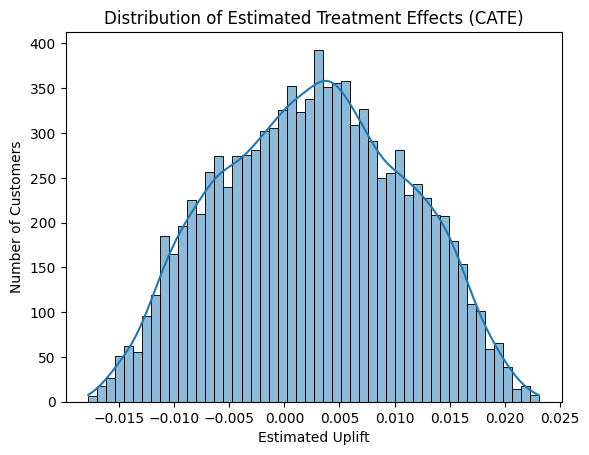

In [78]:
sns.histplot(cate_preds, bins=50, kde=True)
plt.title("Distribution of Estimated Treatment Effects (CATE)")
plt.xlabel("Estimated Uplift")
plt.ylabel("Number of Customers")
plt.show()


The plot reveals that while most customers benefit modestly from discounts, there is significant variability in response reinforcing the need for targeted discount strategies rather than blanket offers.

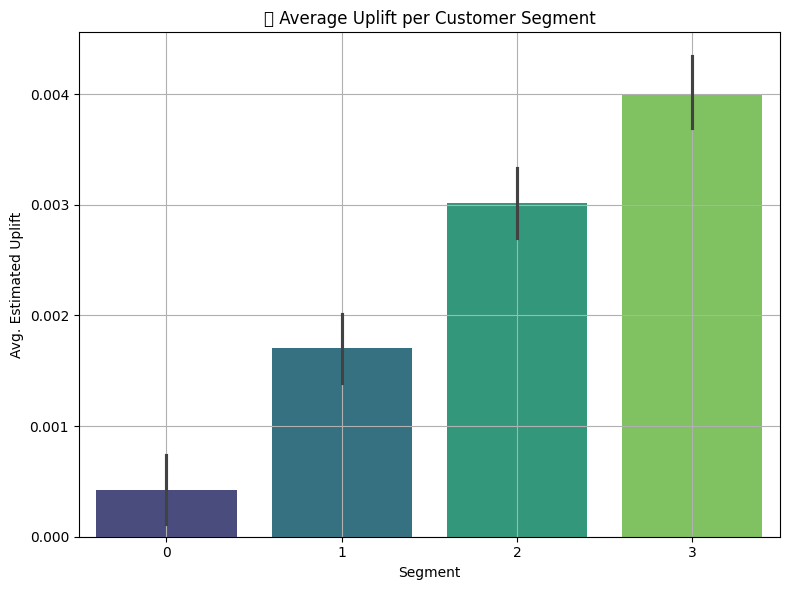

In [80]:
df_test = X_test.copy()
df_test['CATE'] = cate_dr
df_test['Segment'] = X_test['Segment'] 

plt.figure(figsize=(8, 6))
sns.barplot(data=df_test, x='Segment', y='CATE', palette='viridis')
plt.title("Average Uplift per Customer Segment")
plt.xlabel("Segment")
plt.ylabel("Avg. Estimated Uplift")
plt.grid(True)
plt.tight_layout()
plt.show()


Segment 3 customers are the most responsive to discounts followed by Segment 2, while Segment 0 shows negligible benefit, highlighting the potential of segmentvbased targeting to optimize campaign impact.